In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00


In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.nn import Linear, BatchNorm1d

from torch_geometric.nn import CGConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.data import DataLoader
import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [6]:
import os
import numpy as np
from torch_geometric.data import Dataset, Data

In [7]:
import torch
from torch_geometric.data import InMemoryDataset


class forceChainData(InMemoryDataset):
    def __init__(self, root, mu, transform=None, pre_transform=None):
        self.mu = mu
        super(forceChainData, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
      if self.root=="drive/MyDrive/training":
        return ['trainingdata_mu' +str(self.mu)+'.pt']
      else:
        return ['validationdata_mu' +str(self.mu)+'.pt']

    def download(self):
        pass

    def process(self):
        pass


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
train_dataset = forceChainData(root = "drive/MyDrive/training", mu=0.0)
validation_dataset = forceChainData(root = "drive/MyDrive/validation", mu=0.0)

print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')


print('==============================================================')
data = train_dataset[0]  # Get the first graph object.

print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Is directed: {data.is_directed()}')


Number of graphs: 1024
Number of features: 2
Number of classes: 2
Data(x=[400, 2], edge_index=[2, 2256], edge_attr=[2256, 5], y=[400])
Number of nodes: 400
Number of edges: 2256
Average node degree: 5.64
Has isolated nodes: False
Is directed: True


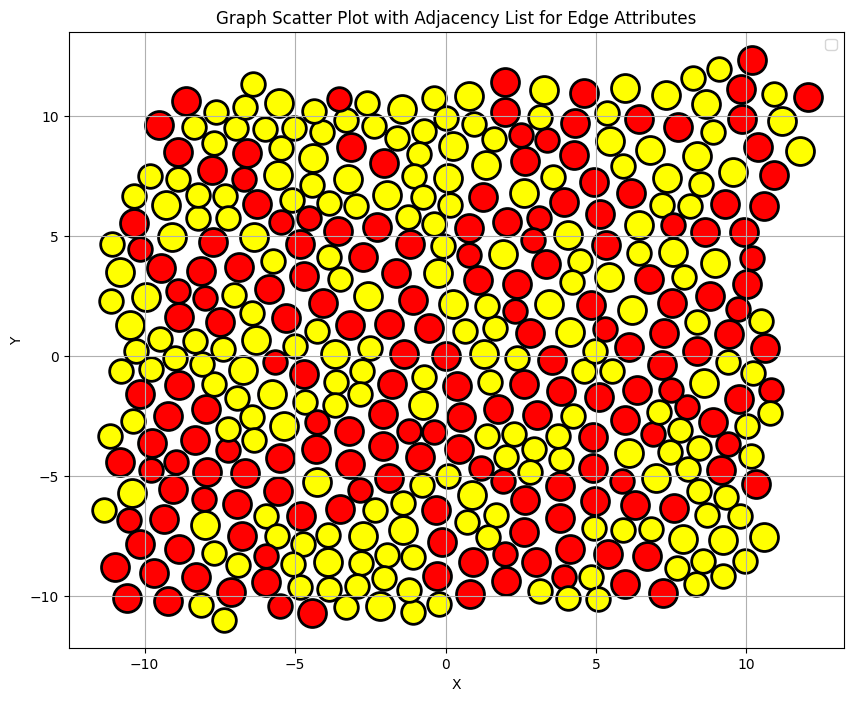

In [10]:
import numpy as np
import matplotlib.pyplot as plt
data=train_dataset[0]
# Extract the first column from the tensor
first_column = data.edge_attr[:, 0]

# Convert the first column to a NumPy array
first_column_np = first_column.numpy()

# Find the maximum value in the first column
max_value = np.max(first_column_np)
# Function to create adjacency list for both edge_index and edge_attr
def edge_data_to_adj_list(edge_index, edge_attr, num_nodes):
    adj_list = [[] for _ in range(num_nodes)]
    i = 0
    while i < edge_index.shape[1]:
        src, dest = edge_index[:, i].tolist()
        adj_list[src].append((dest, *edge_attr[i].tolist()))  # Include all edge attributes
        adj_list[dest].append((src, *edge_attr[i + 1].tolist()))  # Include the inverted attributes for the reverse edge
        i += 2  # Increment by 2 to handle the next pair of edges
    return adj_list

adj_list = edge_data_to_adj_list(data.edge_index, data.edge_attr, data.num_nodes)

# Function to compute node positions using BFS
def compute_positions_bfs(adj_list):
    num_nodes = len(adj_list)
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def bfs(start_node):
        queue = [(start_node, np.array([0, 0]))]  # Initialize queue with the start node and its position
        visited[start_node] = True
        while queue:
            node, parent_pos = queue.pop(0)  # Dequeue the next node and its position
            # Iterate through all neighbors of the current node
            for neighbor, *attrs in adj_list[node]:
                if not visited[neighbor]:
                    dy, dx = attrs[1:3]  # Get relative position from edge attributes
                    neighbor_pos = parent_pos + np.array([dx, dy])  # Compute neighbor's position
                    positions[neighbor] = neighbor_pos
                    visited[neighbor] = True
                    queue.append((neighbor, neighbor_pos))  # Enqueue the neighbor node and its position

    # Start BFS from all unvisited nodes
    for node in range(num_nodes):
        if not visited[num_nodes-node-1]:
            bfs(num_nodes-node-1)

    return positions

positions = compute_positions_bfs(adj_list)

# Extract node labels from data.y
node_labels = data.y.numpy()
node_labels = data.y.numpy()
labels = data.x[:,0].numpy()
size_labels=np.int_(labels)

# Create a scatter plot of the nodes
plt.figure(figsize=(10,8))
for i, pos in enumerate(positions):
    color = 'yellow' if node_labels[i] == 0 else 'red'
    size=404 if size_labels[i]==0 else 290
    plt.scatter(pos[0], pos[1], s=size ,c=color,edgecolor='black',linewidth=2)

plt.grid(True)

# Annotate nodes
# for i, pos in enumerate(positions):
#     plt.annotate(str(i), (pos[0], pos[1]))

# # Draw edges based on adjacency list
# distance_threshold = max_value
# for src, dest_list in enumerate(adj_list):
#     for dest, *attrs in dest_list:
#         distance = np.linalg.norm(positions[src] - positions[dest])
#         if distance < distance_threshold:
#             plt.plot([positions[src][0], positions[dest][0]], [positions[src][1], positions[dest][1]], 'k-', lw=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Adjacency List for Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
class CGCN(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, hidden_channels,
                 num_layers, dropout):
        super(CGCN, self).__init__()
        self.node_transform = Linear(node_dim, hidden_dim)
        self.edge_transform = Linear(edge_dim, hidden_dim)
        self.convs = torch.nn.ModuleList([
            CGConv((2 * hidden_dim, hidden_dim)) for i in range(num_layers)
        ])
        self.bns = torch.nn.ModuleList([
            BatchNorm1d(num_features=hidden_dim) for i in range(num_layers-1)
        ])
        self.MLP = torch.nn.ModuleList([Linear(hidden_dim, hidden_channels[0])] + [Linear(hidden_channels[i], hidden_channels[i+1]) for i in range(len(hidden_channels)-1)])
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = dropout

    def reset_parameters(self):
        self.edge_transform.reset_parameters()
        self.node_transform.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        for dense in self.MLP:
            dense.reset_parameters()

    def forward(self, data, edge_index, edge_attr):
        x = self.node_transform(data)
        edge_attr = self.edge_transform(edge_attr)
        for con, bn in zip(self.convs[:-1], self.bns):
            x = functional.relu(bn(con(x = x, edge_index = edge_index, edge_attr = edge_attr)))
            if self.training:
                x = functional.dropout(x, p=self.dropout)
        x = self.convs[-1](x, edge_index, edge_attr)
        for dense in self.MLP:
            x = functional.relu(dense(x))
            if self.training:
                x = functional.dropout(x, p=self.dropout)
        return functional.log_softmax(x, dim=1)

    def loss(self, pred, label):
        loss = nn.NLLLoss()
        return loss(pred, label)

In [12]:
training_data = forceChainData(root = "drive/MyDrive/training", mu = 0.0)
validating_data = forceChainData(root = 'drive/MyDrive/validation', mu = 0.0)

In [13]:
train_dataset = torch.load('drive/MyDrive/training/processed/trainingdata_mu0.0.pt')
validation_dataset = torch.load('drive/MyDrive/validation/processed/validationdata_mu0.0.pt')

In [14]:
t_data = train_dataset[0]
validation_data = validation_dataset[0]

In [15]:
data =train_dataset[0]

In [16]:
args = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'num_layers': 8,
    'hidden_dim': 64,
    'dropout': 0.5,
    'learning_rate': 0.001,
    'epochs': 200,
    'loss': nn.NLLLoss(),
    'hidden_layer_dimensions': [256, 256, 2]
}
device = args['device']

In [17]:
training_data.data.to(device)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[409600, 2], edge_index=[2, 2285844], edge_attr=[2285844, 5], y=[409600])

In [18]:
training_history = []
validation_accuracy = []

In [19]:
def train(dataset, validation_dataset, task, writer):

    model = CGCN(node_dim=data.x.shape[1], edge_dim=data.edge_attr.shape[1], hidden_dim = args['hidden_dim'],
             hidden_channels=args['hidden_layer_dimensions'], num_layers=args['num_layers'], dropout=args['dropout'])
    dataset.data.to(device)
    validation_dataset.data.to(device)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=args['learning_rate'])
    model.to(device)
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            out = model(batch.x, batch.edge_index, batch.edge_attr)
            label = batch.y
            loss = model.loss(out.squeeze(), label)
            loss.backward()
            opt.step()
            total_loss += loss.detach().item()
        total_loss /= len(dataset)
        training_history.append(total_loss)
        writer.add_scalar('loss', total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(validation_loader, model)
            validation_accuracy.append(test_acc)
            print('Epoch {}, Loss: {:.4f},  Test accuracy: {: .4f}'.format(epoch, total_loss, test_acc))
            writer.add_scalar('test accuracy', test_acc, epoch)

    return model

In [20]:
def test(loader, model, is_validation=True):
    model.eval()

    correct = 0; total = 0
    for data in loader:
        with torch.no_grad():
            data.x = data.x[:, :2]
            pred = model(data.x, data.edge_index, data.edge_attr)
            pred = pred.argmax(dim=1)
            label = data.y
            total += len(pred)
            correct += pred.eq(label).sum().item()
    return correct / total

In [21]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [24]:
model = train(training_data, validating_data, 'node', writer)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warnin

Epoch 0, Loss: 0.0109,  Test accuracy:  0.5655
Epoch 10, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 20, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 30, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 40, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 50, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 60, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 70, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 80, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 90, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 100, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 110, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 120, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 130, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 140, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 150, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 160, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 170, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 180, Loss: 0.0108,  Test accuracy:  0.5655
Epoch 190, Loss: 0.0108,  Test accuracy:  0.5655


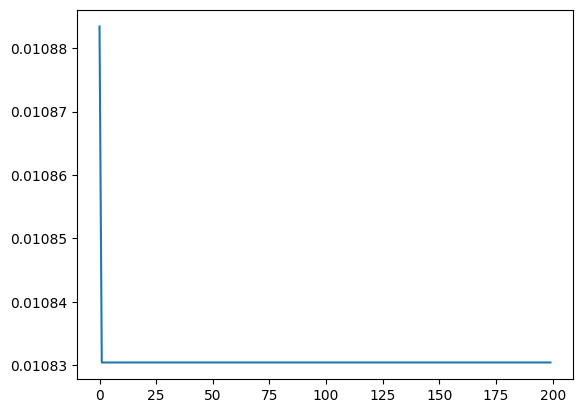

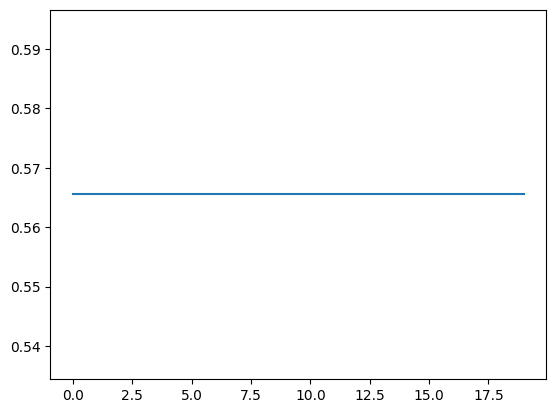

In [25]:
import matplotlib.pyplot as plt

plt.plot(training_history)
plt.figure()
plt.plot(validation_accuracy)

In [ ]:
from collections import deque
import matplotlib.pyplot as plt
# Function to perform BFS and determine node positions
def bfs_plot(adj_list, start_node):
    visited = set()
    queue = deque([(start_node, (0, 0))])
    positions = {start_node: (0, 0)}
    edges = []

    while queue:
        current_node, current_pos = queue.popleft()
        if current_node not in visited:
            print(f"Starting BFS from node {current_node}")
            visited.add(current_node)
            for neighbor, attr in adj_list[current_node]:
                if neighbor not in visited:
                    dx = attr[1]  # Assume dx is in the 2nd column of edge_attr
                    dy = attr[2]  # Assume dy is in the 3rd column of edge_attr
                    neighbor_pos = (current_pos[0] + dx, current_pos[1] + dy)
                    positions[neighbor] = neighbor_pos
                    queue.append((neighbor, neighbor_pos))
                    edges.append((current_node, neighbor))

    return positions, edges

# Identify all components and perform BFS for each component
all_positions = {}
all_edges = []
for node in adj_list.keys():
    if node not in all_positions:
        component_positions, component_edges = bfs_plot(adj_list, node)
        all_positions.update(component_positions)
        all_edges.extend(component_edges)

# Extract x and y coordinates for plotting
x_coords = [pos[0] for pos in all_positions.values()]
y_coords = [pos[1] for pos in all_positions.values()]
node_labels = list(all_positions.keys())

# Plot the graph
plt.figure(figsize=(20, 18))
plt.scatter(x_coords, y_coords)

# # # Draw edges
# for edge in all_edges:
#     start_node, end_node = edge
#     start_pos = all_positions[start_node]
#     end_pos = all_positions[end_node]
#     plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-')

# Annotate nodes
for label, x, y in zip(node_labels, x_coords, y_coords):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Graph Visualization using BFS")
plt.grid(True)
plt.show()

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
def print_neighbors(adj_list, node):
    if node in adj_list:
        neighbors = adj_list[node]
        print(f"Neighbors of node {node}:")
        for neighbor, attr in neighbors:
            print(f"Neighbor: {neighbor}, Edge Attributes: {attr}")
    else:
        print(f"Node {node} has no neighbors.")

# Print neighbors of node 26
print_neighbors(adj_list, 371)

Neighbors of node 371:
Neighbor: 45, Edge Attributes: [1.179918885231018, -0.799239993095398, 0.8679999709129333, 0.7356438040733337, -0.6773685812950134]
Neighbor: 52, Edge Attributes: [1.112093448638916, -1.0008599758148193, -0.4848000109195709, -0.4359346032142639, -0.8999783396720886]
Neighbor: 114, Edge Attributes: [0.9315701723098755, 0.9274799823760986, -0.08720000088214874, -0.0936053991317749, 0.9956094026565552]
Neighbor: 204, Edge Attributes: [0.9883180856704712, 0.020759999752044678, -0.988099992275238, -0.9997793436050415, 0.021005382761359215]
Neighbor: 299, Edge Attributes: [1.1517294645309448, 0.5817599892616272, 0.9940000176429749, 0.8630499243736267, 0.5051186084747314]
Neighbor: 390, Edge Attributes: [1.3762030601501465, 0.9557399749755859, -0.9901999831199646, -0.719515860080719, 0.6944760084152222]


In [ ]:
for node, pos in all_positions.items():
    print(f"Node {node}: Position {pos}")

Node 26: Position (0, 0)
Node 1: Position (-1.3325999975204468, 0.027559999376535416)
Node 136: Position (-0.6218000054359436, 1.1909999884665012)
Node 175: Position (1.1318000555038452, 0.029079999774694443)
Node 240: Position (0.7213000655174255, 1.0926299951970577)
Node 335: Position (-0.6075000166893005, -1.1483099423348904)
Node 346: Position (0.5727999806404114, -1.0020599514245987)
Node 111: Position (-1.7723000645637512, 1.128059983253479)
Node 215: Position (-1.9161999821662903, -1.189929947257042)
Node 339: Position (-2.622600018978119, 0.34751999750733376)
Node 305: Position (0.20440000295639038, 2.0603400468826294)
Node 393: Position (-0.8155999779701233, 2.488329976797104)
Node 50: Position (1.512499988079071, -0.8374700546264648)
Node 193: Position (2.0610000491142273, -0.04249003902077675)
Node 223: Position (2.0101000480353832, 1.0980399884283543)
Node 135: Position (1.3452000617980957, 2.29981991276145)
Node 123: Position (-1.2092999815940857, -2.1291799508035183)
Node

curr nod:(26,(0, 0),,,,,,,,,,1,(-1.3325999975204468, 0.027559999376535416))
curr nod:(26,(0, 0),,,,,,,,,,136,(-0.6218000054359436, 1.190999984741211))
curr nod:(26,(0, 0),,,,,,,,,,175,(1.1318000555038452, 0.029079999774694443))
curr nod:(26,(0, 0),,,,,,,,,,240,(0.7213000059127808, 1.0926300287246704))
curr nod:(26,(0, 0),,,,,,,,,,335,(-0.6075000166893005, -1.1483099460601807))
curr nod:(26,(0, 0),,,,,,,,,,346,(0.5727999806404114, -1.002060055732727))
curr nod:(136,(-0.6218000054359436, 1.190999984741211),,,,,,,,,,305,(0.20440000295639038, 2.0603399872779846))
curr nod:(136,(-0.6218000054359436, 1.190999984741211),,,,,,,,,,393,(-0.8156000077724457, 2.4883300065994263))
curr nod:(335,(-0.6075000166893005, -1.1483099460601807),,,,,,,,,,123,(-1.2093000411987305, -2.1291799545288086))
curr nod:(335,(-0.6075000166893005, -1.1483099460601807),,,,,,,,,,236,(0.21649998426437378, -1.88919997215271))
curr nod:(111,(-1.7723000049591064, 1.1280599869787693),,,,,,,,,,76,(-1.856000006198883, 2.089469

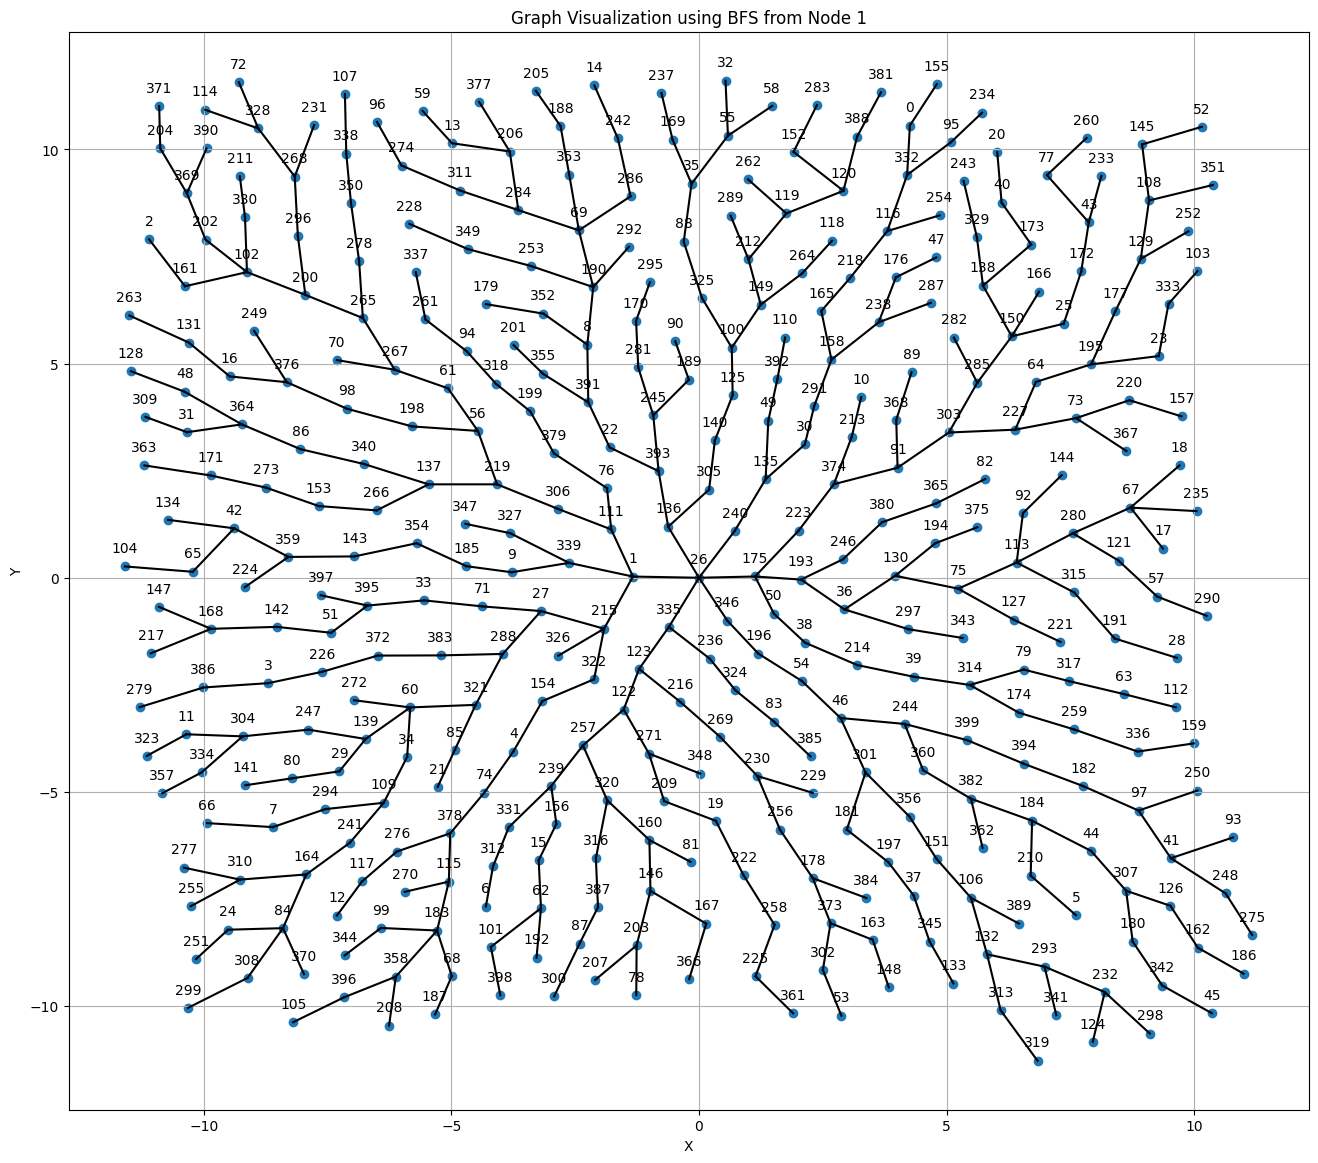

In [ ]:
import torch
from collections import defaultdict, deque
import matplotlib.pyplot as plt
edge_index=data.edge_index
edge_attr=data.edge_attr
# Initialize the adjacency list
adj_list = defaultdict(list)

# Populate the adjacency list
for i in range(edge_index.size(1)):
    start_node = edge_index[0, i].item()
    end_node = edge_index[1, i].item()
    attributes = edge_attr[i].tolist()  # Convert tensor to list
    adj_list[start_node].append((end_node, attributes))

# Function to perform BFS and determine node positions
def bfs_plot(adj_list, start_node):
    visited = set()
    queue = deque([(start_node, (0, 0))])
    positions = {start_node: (0, 0)}
    edges = []

    while queue:
        current_node, current_pos = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            for neighbor, attr in adj_list[current_node]:
                if neighbor not in positions:
                    dx = attr[1]  # Assume dx is in the 2nd column of edge_attr
                    dy = attr[2]  # Assume dy is in the 3rd column of edge_attr
                    neighbor_pos = (current_pos[0] + dx, current_pos[1] + dy)
                    positions[neighbor] = neighbor_pos
                    queue.append((neighbor, neighbor_pos))
                    edges.append((current_node, neighbor))
                    if current_node==136 or current_node==335 or current_node==111 or current_node==339 or current_node==215 or current_node==26:
                      print(f"curr nod:({current_node},{current_pos},,,,,,,,,,{neighbor},{neighbor_pos})")

    return positions, edges

# Perform BFS starting from node 371
start_node = 26
positions, edges = bfs_plot(adj_list, start_node)


# Extract x and y coordinates for plotting
x_coords = [pos[0] for pos in positions.values()]
y_coords = [pos[1] for pos in positions.values()]
node_labels = list(positions.keys())

# Plot the graph
plt.figure(figsize=(16, 14))
plt.scatter(x_coords, y_coords)

# # Draw edges
for edge in edges:
    start_node, end_node = edge
    start_pos = positions[start_node]
    end_pos = positions[end_node]
    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-')

# Annotate nodes
for label, x, y in zip(node_labels, x_coords, y_coords):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Graph Visualization using BFS from Node 1")
plt.grid(True)
plt.show()


curr nod:(111,(9.125279977917671, -9.885960057377815),,,,,,,,,,1,(9.56497998535633, -10.98646004498005))
curr nod:(111,(9.125279977917671, -9.885960057377815),,,,,,,,,,136,(10.275780037045479, -9.823020055890083))


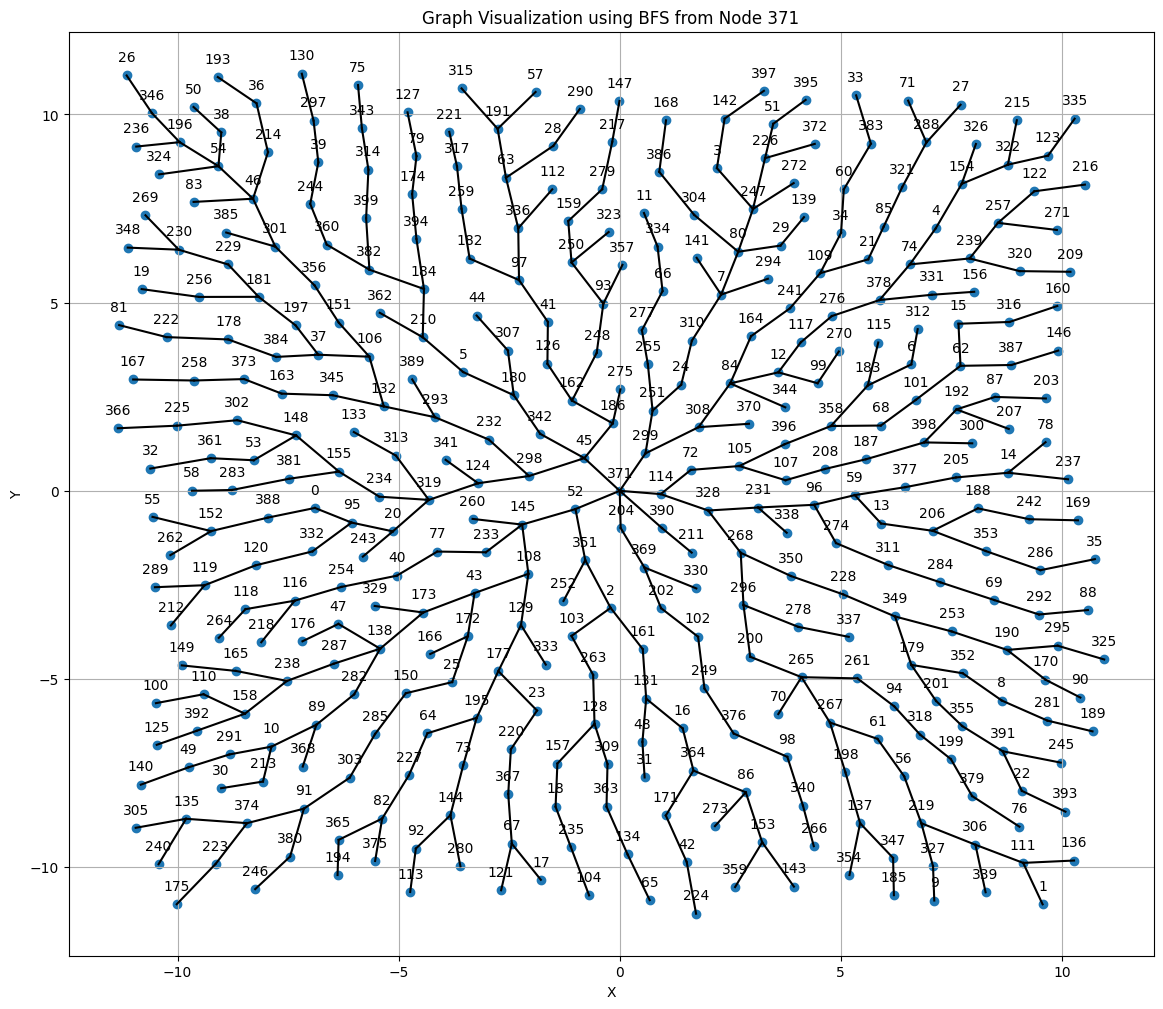

In [ ]:
import torch
from collections import defaultdict, deque
import matplotlib.pyplot as plt
edge_index=data.edge_index
edge_attr=data.edge_attr
# Initialize the adjacency list
adj_list = defaultdict(list)

# Populate the adjacency list
for i in range(edge_index.size(1)):
    start_node = edge_index[0, i].item()
    end_node = edge_index[1, i].item()
    attributes = edge_attr[i].tolist()  # Convert tensor to list
    adj_list[start_node].append((end_node, attributes))

# Function to perform BFS and determine node positions
def bfs_plot(adj_list, start_node):
    visited = set()
    queue = deque([(start_node, (0, 0))])
    positions = {start_node: (0, 0)}
    edges = []

    while queue:
        current_node, current_pos = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            for neighbor, attr in adj_list[current_node]:
                if neighbor not in positions:
                    dx = attr[1]  # Assume dx is in the 2nd column of edge_attr
                    dy = attr[2]  # Assume dy is in the 3rd column of edge_attr
                    neighbor_pos = (current_pos[0] + dx, current_pos[1] + dy)
                    positions[neighbor] = neighbor_pos
                    queue.append((neighbor, neighbor_pos))
                    edges.append((current_node, neighbor))
                    if current_node==136 or current_node==335 or current_node==111 or current_node==339 or current_node==215 or current_node==26:
                      print(f"curr nod:({current_node},{current_pos},,,,,,,,,,{neighbor},{neighbor_pos})")

    return positions, edges

# Perform BFS starting from node 371
start_node = 371
positions, edges = bfs_plot(adj_list, start_node)


# Extract x and y coordinates for plotting
x_coords = [pos[0] for pos in positions.values()]
y_coords = [pos[1] for pos in positions.values()]
node_labels = list(positions.keys())

# Plot the graph
plt.figure(figsize=(14, 12))
plt.scatter(x_coords, y_coords)

# # Draw edges
for edge in edges:
    start_node, end_node = edge
    start_pos = positions[start_node]
    end_pos = positions[end_node]
    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-')

# Annotate nodes
for label, x, y in zip(node_labels, x_coords, y_coords):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Graph Visualization using BFS from Node 371")
plt.grid(True)
plt.show()


Starting BFS from node 191


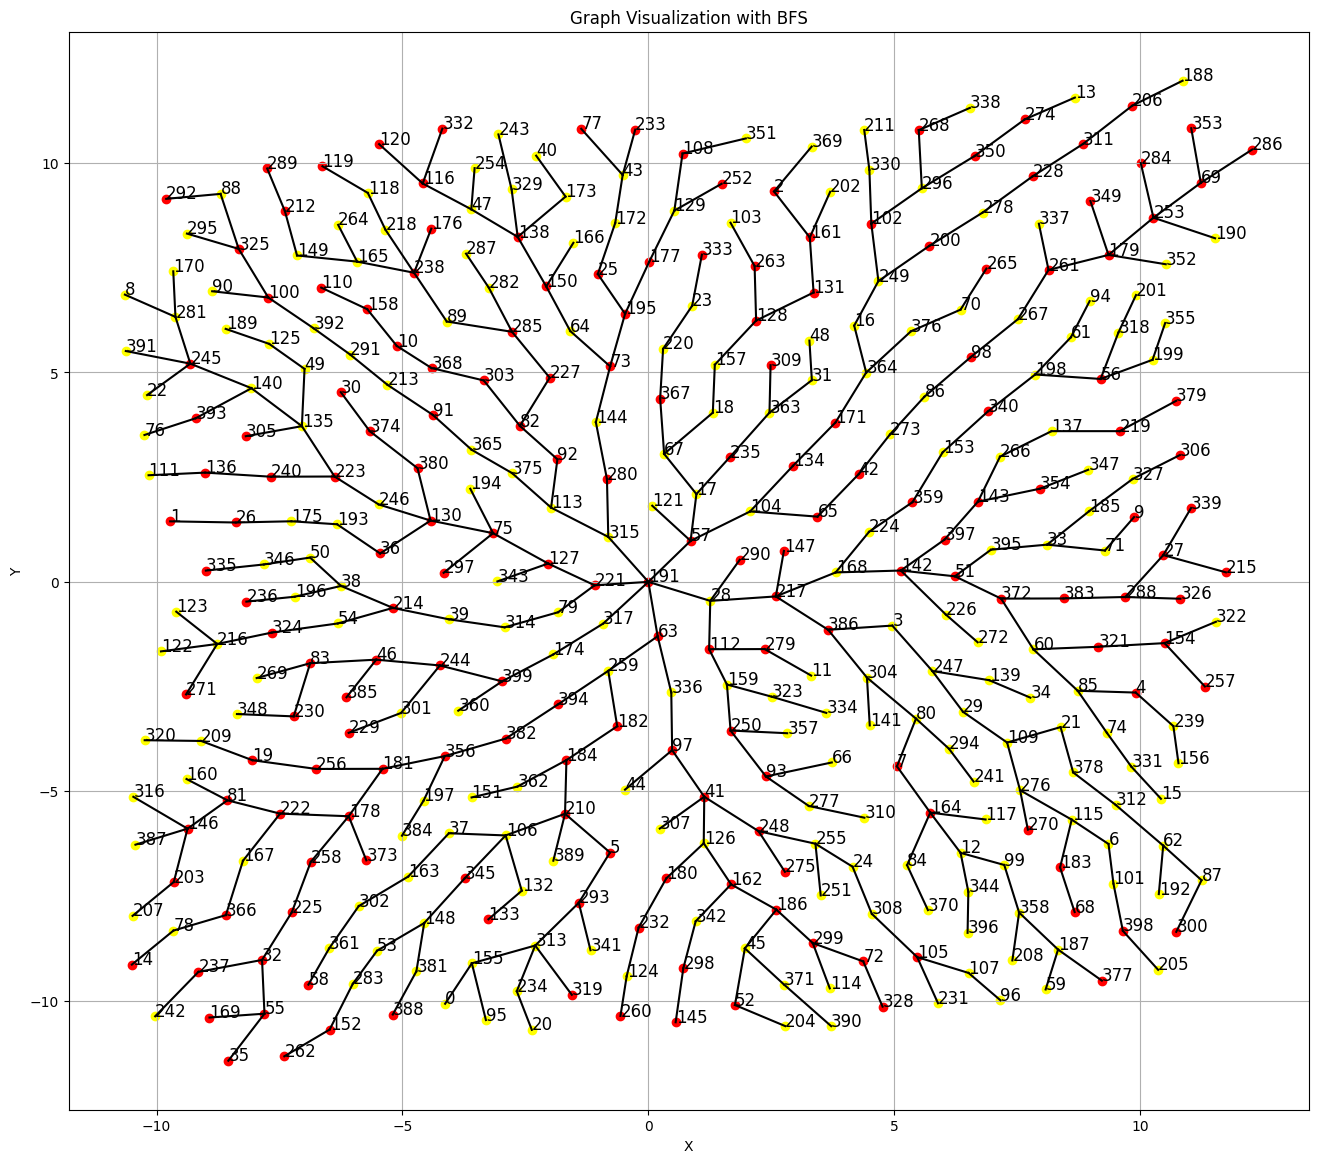

In [ ]:
def bfs_positions(adj_list, start_node):
    visited = set()
    queue = deque([(start_node, (0, 0))])
    positions = {start_node: (0, 0)}
    edges = []

    print(f"Starting BFS from node {start_node}")

    while queue:
        current_node, current_pos = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            # print(f"Visited node {current_node}, Position: {current_pos}")
            for neighbor, attr in adj_list[current_node]:
                if neighbor not in positions:  # Check if neighbor position is already known
                    dx = attr[1]  # Assume dx is in the 2nd column of edge_attr
                    dy = attr[2]  # Assume dy is in the 3rd column of edge_attr
                    neighbor_pos = (current_pos[0] + dx, current_pos[1] + dy)
                    positions[neighbor] = neighbor_pos
                    queue.append((neighbor, neighbor_pos))
                    edges.append((current_node, neighbor))

    return positions, edges

# Example usage:
start_node = 191
positions, edges = bfs_positions(adj_list, start_node)

# Set figure size
plt.figure(figsize=(16, 14))

# Plot edges
for edge in edges:
    start_node, end_node = edge
    start_pos = positions[start_node]
    end_pos = positions[end_node]
    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-')

# Assuming data.y contains node attribute 'y'
# Sample node colors based on 'y' attribute
node_colors = {node: data.y[node] for node in range(len(data.y))}
# Plot colored nodes
for node, pos in positions.items():
    node_color = 'yellow' if node_colors[node] == 0 else 'red'
    plt.scatter(pos[0], pos[1], color=node_color)

# Add node labels
for node, pos in positions.items():
    plt.text(pos[0], pos[1], str(node), fontsize=12)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Graph Visualization with BFS")
plt.grid(True)
plt.show()


In [ ]:
!pip install torch torchvision torch-geometric matplotlib


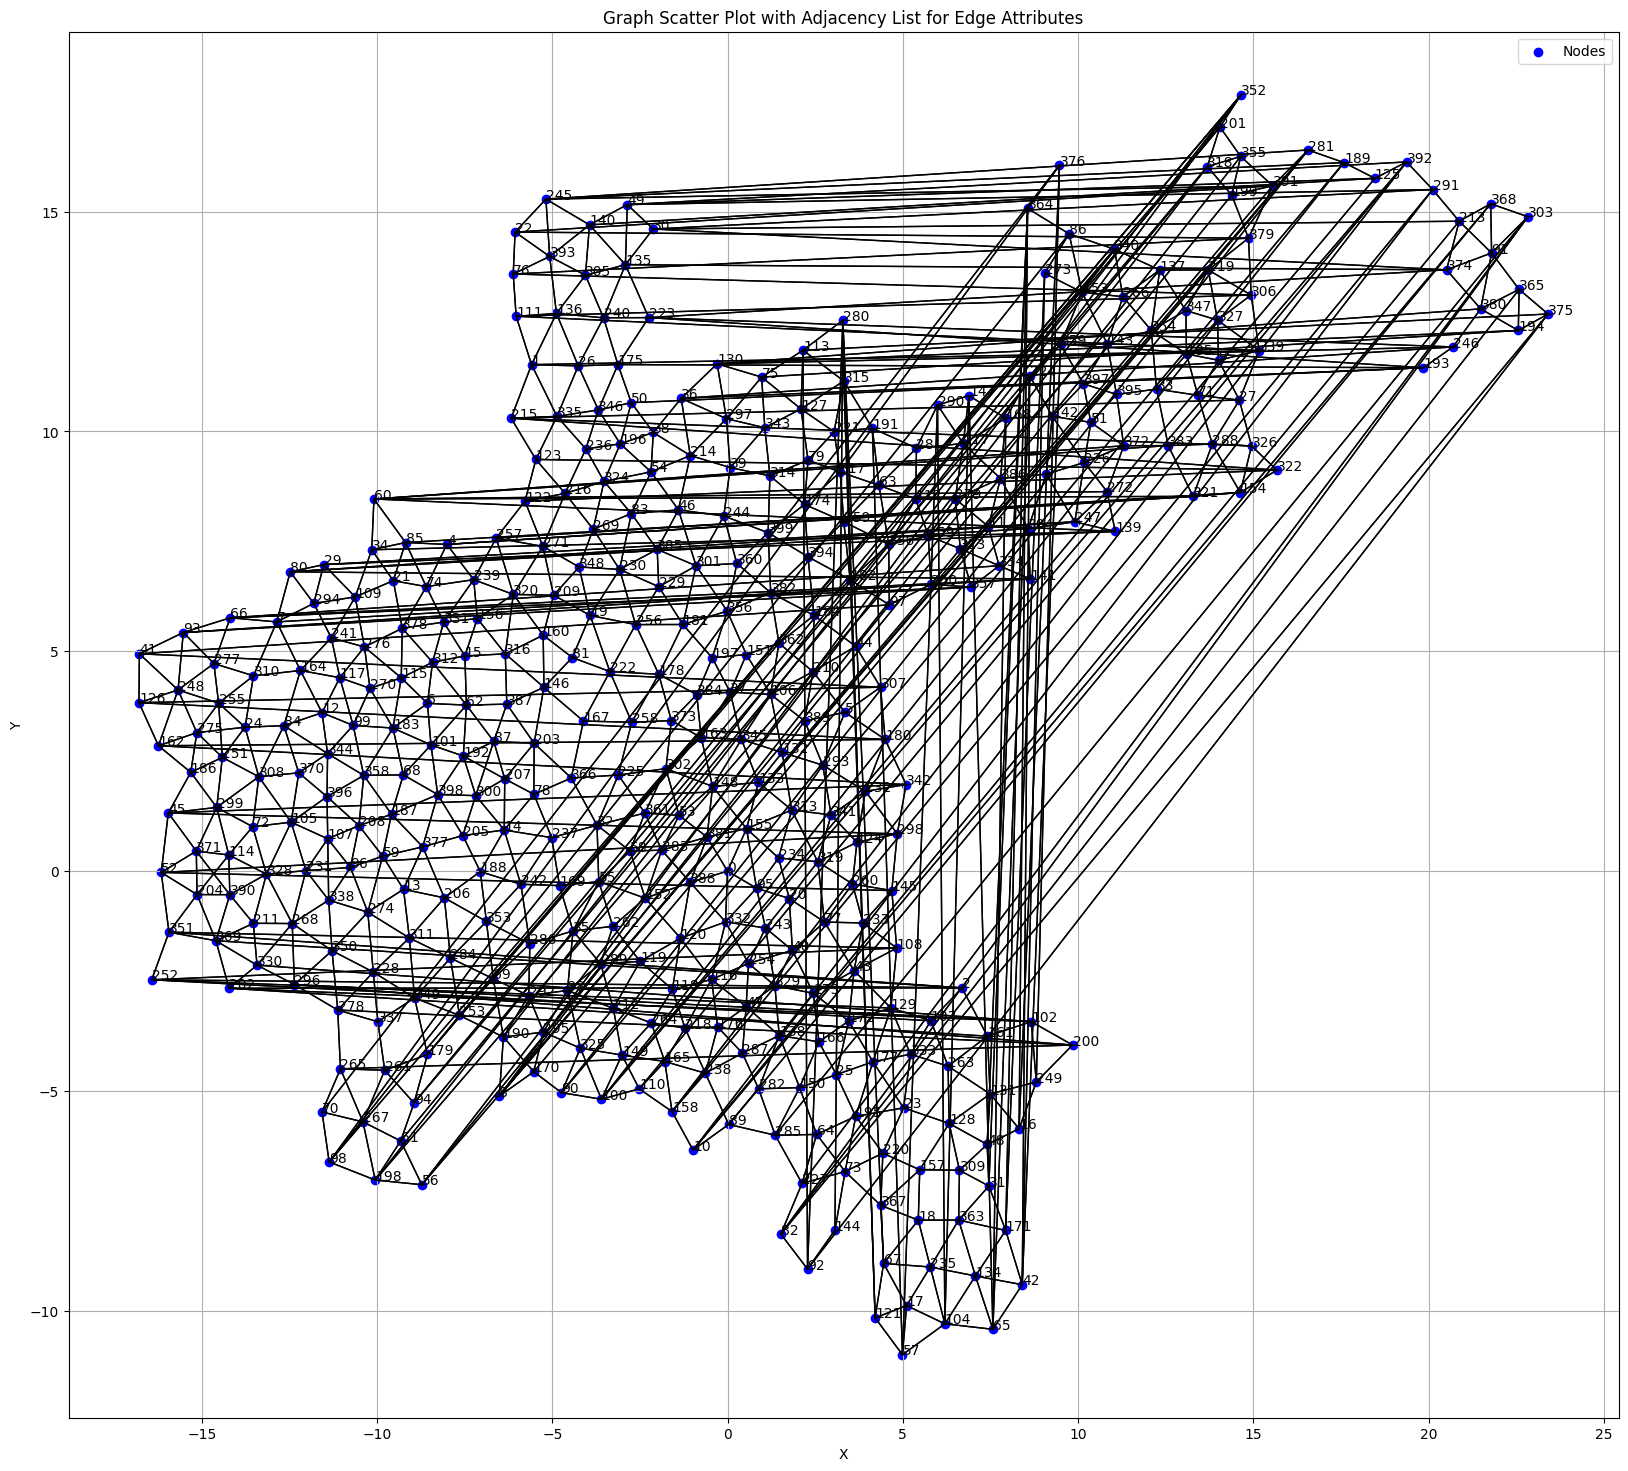

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data=train_dataset[0]

# Function to create adjacency list for both edge_index and edge_attr
def edge_data_to_adj_list(edge_index, edge_attr, num_nodes):
    adj_list = [[] for _ in range(num_nodes)]
    i = 0
    while i < edge_index.shape[1]:
        src, dest = edge_index[:, i].tolist()
        adj_list[src].append((dest, *edge_attr[i].tolist()))  # Include all edge attributes
        adj_list[dest].append((src, *edge_attr[i + 1].tolist()))  # Include the inverted attributes for the reverse edge
        i += 2  # Increment by 2 to handle the next pair of edges
    return adj_list

adj_list = edge_data_to_adj_list(data.edge_index, data.edge_attr, data.num_nodes)

# Function to compute node positions
def compute_positions(adj_list):
    num_nodes = len(adj_list)
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def dfs(node, parent_pos=np.array([0, 0])):
        visited[node] = True  # Mark the current node as visited
        # Iterate through all neighbors of the current node
        for neighbor, *attrs in adj_list[node]:
            if not visited[neighbor]:
                dx, dy = attrs[1:3]  # Get relative position from edge attributes
                neighbor_pos = parent_pos + np.array([dx, dy])  # Compute neighbor's position
                positions[neighbor] = neighbor_pos
                # Recursively call DFS on the neighbor node
                dfs(neighbor, neighbor_pos)

    # Start DFS from all unvisited nodes
    for node in range(num_nodes):
        if not visited[node]:
            dfs(node)

    return positions

positions = compute_positions(adj_list)

# Create a scatter plot of the nodes
plt.figure(figsize=(20, 18))
plt.scatter(positions[:, 0], positions[:, 1], c='blue', label='Nodes')
plt.grid(True)

# Annotate nodes
for i, pos in enumerate(positions):
    plt.annotate(str(i), (pos[0], pos[1]))

# Draw edges based on adjacency list
for src, dest_list in enumerate(adj_list):
    for dest, *attrs in dest_list:
        plt.plot([positions[src][0], positions[dest][0]], [positions[src][1], positions[dest][1]], 'k-', lw=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Adjacency List for Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()


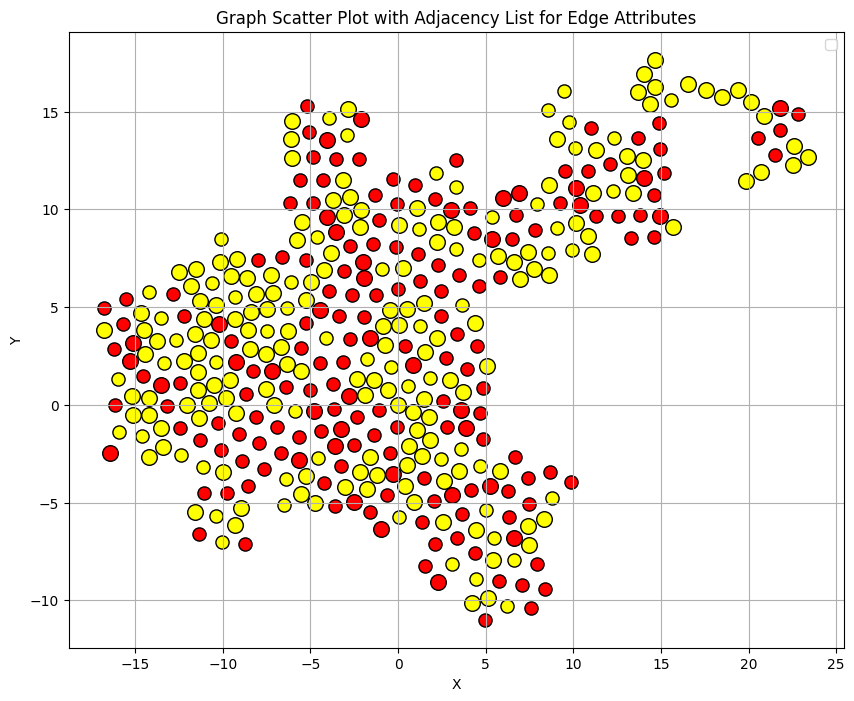

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data=train_dataset[0]
# Extract the first column from the tensor
first_column = data.edge_attr[:, 0]

# Convert the first column to a NumPy array
first_column_np = first_column.numpy()

# Find the maximum value in the first column
max_value = np.max(first_column_np)
# Function to create adjacency list for both edge_index and edge_attr
def edge_data_to_adj_list(edge_index, edge_attr, num_nodes):
    adj_list = [[] for _ in range(num_nodes)]
    i = 0
    while i < edge_index.shape[1]:
        src, dest = edge_index[:, i].tolist()
        adj_list[src].append((dest, *edge_attr[i].tolist()))  # Include all edge attributes
        adj_list[dest].append((src, *edge_attr[i + 1].tolist()))  # Include the inverted attributes for the reverse edge
        i += 2  # Increment by 2 to handle the next pair of edges
    return adj_list

adj_list = edge_data_to_adj_list(data.edge_index, data.edge_attr, data.num_nodes)

# Function to compute node positions
def compute_positions(adj_list):
    num_nodes = len(adj_list)
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def dfs(node, parent_pos=np.array([0, 0])):
        visited[node] = True  # Mark the current node as visited
        # Iterate through all neighbors of the current node
        for neighbor, *attrs in adj_list[node]:
            if not visited[neighbor]:
                dx, dy = attrs[1:3]  # Get relative position from edge attributes
                neighbor_pos = parent_pos + np.array([dx, dy])  # Compute neighbor's position
                positions[neighbor] = neighbor_pos
                # Recursively call DFS on the neighbor node
                dfs(neighbor, neighbor_pos)

    # Start DFS from all unvisited nodes
    for node in range(num_nodes):
        if not visited[node]:
            dfs(node)

    return positions

positions = compute_positions(adj_list)


# Extract node labels from data.y
node_labels = data.y.numpy()
labels = data.x[:,0].numpy()
size_labels=np.int_(labels)

# Create a scatter plot of the nodes
plt.figure(figsize=(10, 8))
for i, pos in enumerate(positions):
    color = 'yellow' if node_labels[i] == 0 else 'red'
    size=126 if size_labels[i]==1 else 90
    plt.scatter(pos[0], pos[1], s=size ,c=color,edgecolor='black')

plt.grid(True)

# Annotate nodes
# for i, pos in enumerate(positions):
#     plt.annotate(str(i), (pos[0], pos[1]))

# # Draw edges based on adjacency list
# distance_threshold = max_value
# for src, dest_list in enumerate(adj_list):
#     for dest, *attrs in dest_list:
#         distance = np.linalg.norm(positions[src] - positions[dest])
#         if distance < distance_threshold:
#             plt.plot([positions[src][0], positions[dest][0]], [positions[src][1], positions[dest][1]], 'k-', lw=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Adjacency List for Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()

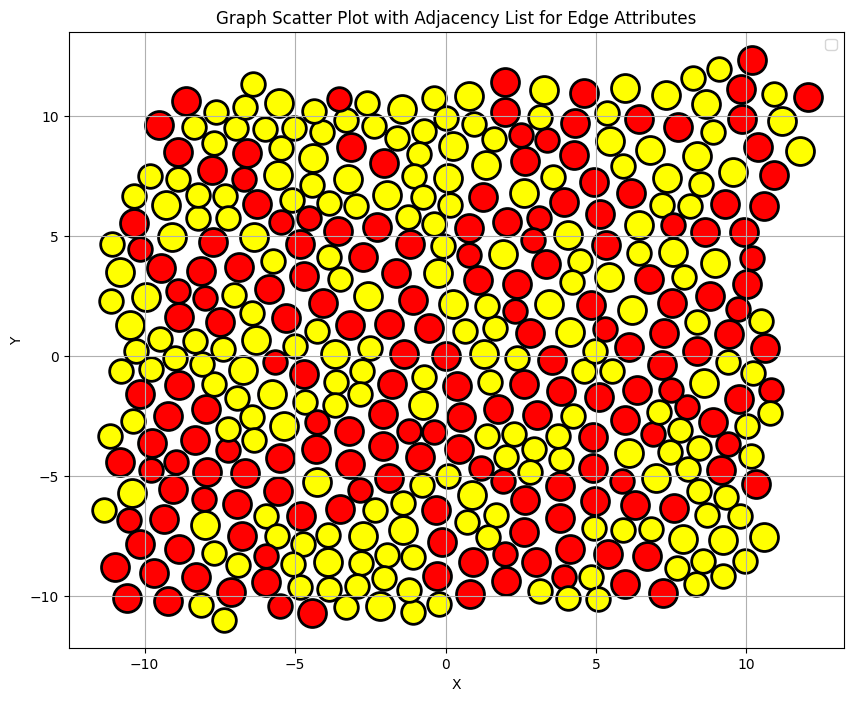

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data=train_dataset[0]
# Extract the first column from the tensor
first_column = data.edge_attr[:, 0]

# Convert the first column to a NumPy array
first_column_np = first_column.numpy()

# Find the maximum value in the first column
max_value = np.max(first_column_np)
# Function to create adjacency list for both edge_index and edge_attr
def edge_data_to_adj_list(edge_index, edge_attr, num_nodes):
    adj_list = [[] for _ in range(num_nodes)]
    i = 0
    while i < edge_index.shape[1]:
        src, dest = edge_index[:, i].tolist()
        adj_list[src].append((dest, *edge_attr[i].tolist()))  # Include all edge attributes
        adj_list[dest].append((src, *edge_attr[i + 1].tolist()))  # Include the inverted attributes for the reverse edge
        i += 2  # Increment by 2 to handle the next pair of edges
    return adj_list

adj_list = edge_data_to_adj_list(data.edge_index, data.edge_attr, data.num_nodes)

# Function to compute node positions using BFS
def compute_positions_bfs(adj_list):
    num_nodes = len(adj_list)
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def bfs(start_node):
        queue = [(start_node, np.array([0, 0]))]  # Initialize queue with the start node and its position
        visited[start_node] = True
        while queue:
            node, parent_pos = queue.pop(0)  # Dequeue the next node and its position
            # Iterate through all neighbors of the current node
            for neighbor, *attrs in adj_list[node]:
                if not visited[neighbor]:
                    dy, dx = attrs[1:3]  # Get relative position from edge attributes
                    neighbor_pos = parent_pos + np.array([dx, dy])  # Compute neighbor's position
                    positions[neighbor] = neighbor_pos
                    visited[neighbor] = True
                    queue.append((neighbor, neighbor_pos))  # Enqueue the neighbor node and its position

    # Start BFS from all unvisited nodes
    for node in range(num_nodes):
        if not visited[num_nodes-node-1]:
            bfs(num_nodes-node-1)

    return positions

positions = compute_positions_bfs(adj_list)

# Extract node labels from data.y
node_labels = data.y.numpy()
node_labels = data.y.numpy()
labels = data.x[:,0].numpy()
size_labels=np.int_(labels)

# Create a scatter plot of the nodes
plt.figure(figsize=(10,8))
for i, pos in enumerate(positions):
    color = 'yellow' if node_labels[i] == 0 else 'red'
    size=404 if size_labels[i]==0 else 290
    plt.scatter(pos[0], pos[1], s=size ,c=color,edgecolor='black',linewidth=2)

plt.grid(True)

# Annotate nodes
# for i, pos in enumerate(positions):
#     plt.annotate(str(i), (pos[0], pos[1]))

# # Draw edges based on adjacency list
# distance_threshold = max_value
# for src, dest_list in enumerate(adj_list):
#     for dest, *attrs in dest_list:
#         distance = np.linalg.norm(positions[src] - positions[dest])
#         if distance < distance_threshold:
#             plt.plot([positions[src][0], positions[dest][0]], [positions[src][1], positions[dest][1]], 'k-', lw=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Adjacency List for Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
connected_nodes=set()
for i in range(data.edge_index.size(1)):
    source, target = data.edge_index[:, i]
    if source == 1:
        connected_nodes.add(target.item())
    elif target == 1:
        connected_nodes.add(source.item())

print("Nodes connected to node 1:", connected_nodes)

Nodes connected to node 1: {136, 335, 111, 339, 215, 26}


In [ ]:
print(data.edge_attr)
import numpy as np
# 1.77662241 1.77582276 0.00076176

tensor([[ 1.3329, -1.3326,  0.0276,  0.0207, -0.9998],
        [ 1.3329,  1.3326, -0.0276, -0.0207,  0.9998],
        [ 1.0843, -0.5950,  0.9064,  0.8360, -0.5488],
        ...,
        [ 1.3686, -0.0744,  1.3666,  0.9985, -0.0544],
        [ 1.2636,  1.1381, -0.5491, -0.4345,  0.9007],
        [ 1.2636, -1.1381,  0.5491,  0.4345, -0.9007]])


In [ ]:
import matplotlib.pyplot as plt
data=train_dataset[0]

[-4.25809983 11.49077993]
[-6.0303999  12.61883992]
[-4.87989984 12.68177992]
[-6.17429982 10.30084997]
[-4.86559973 10.34247006]
[15.16930016 11.83829986]
1128


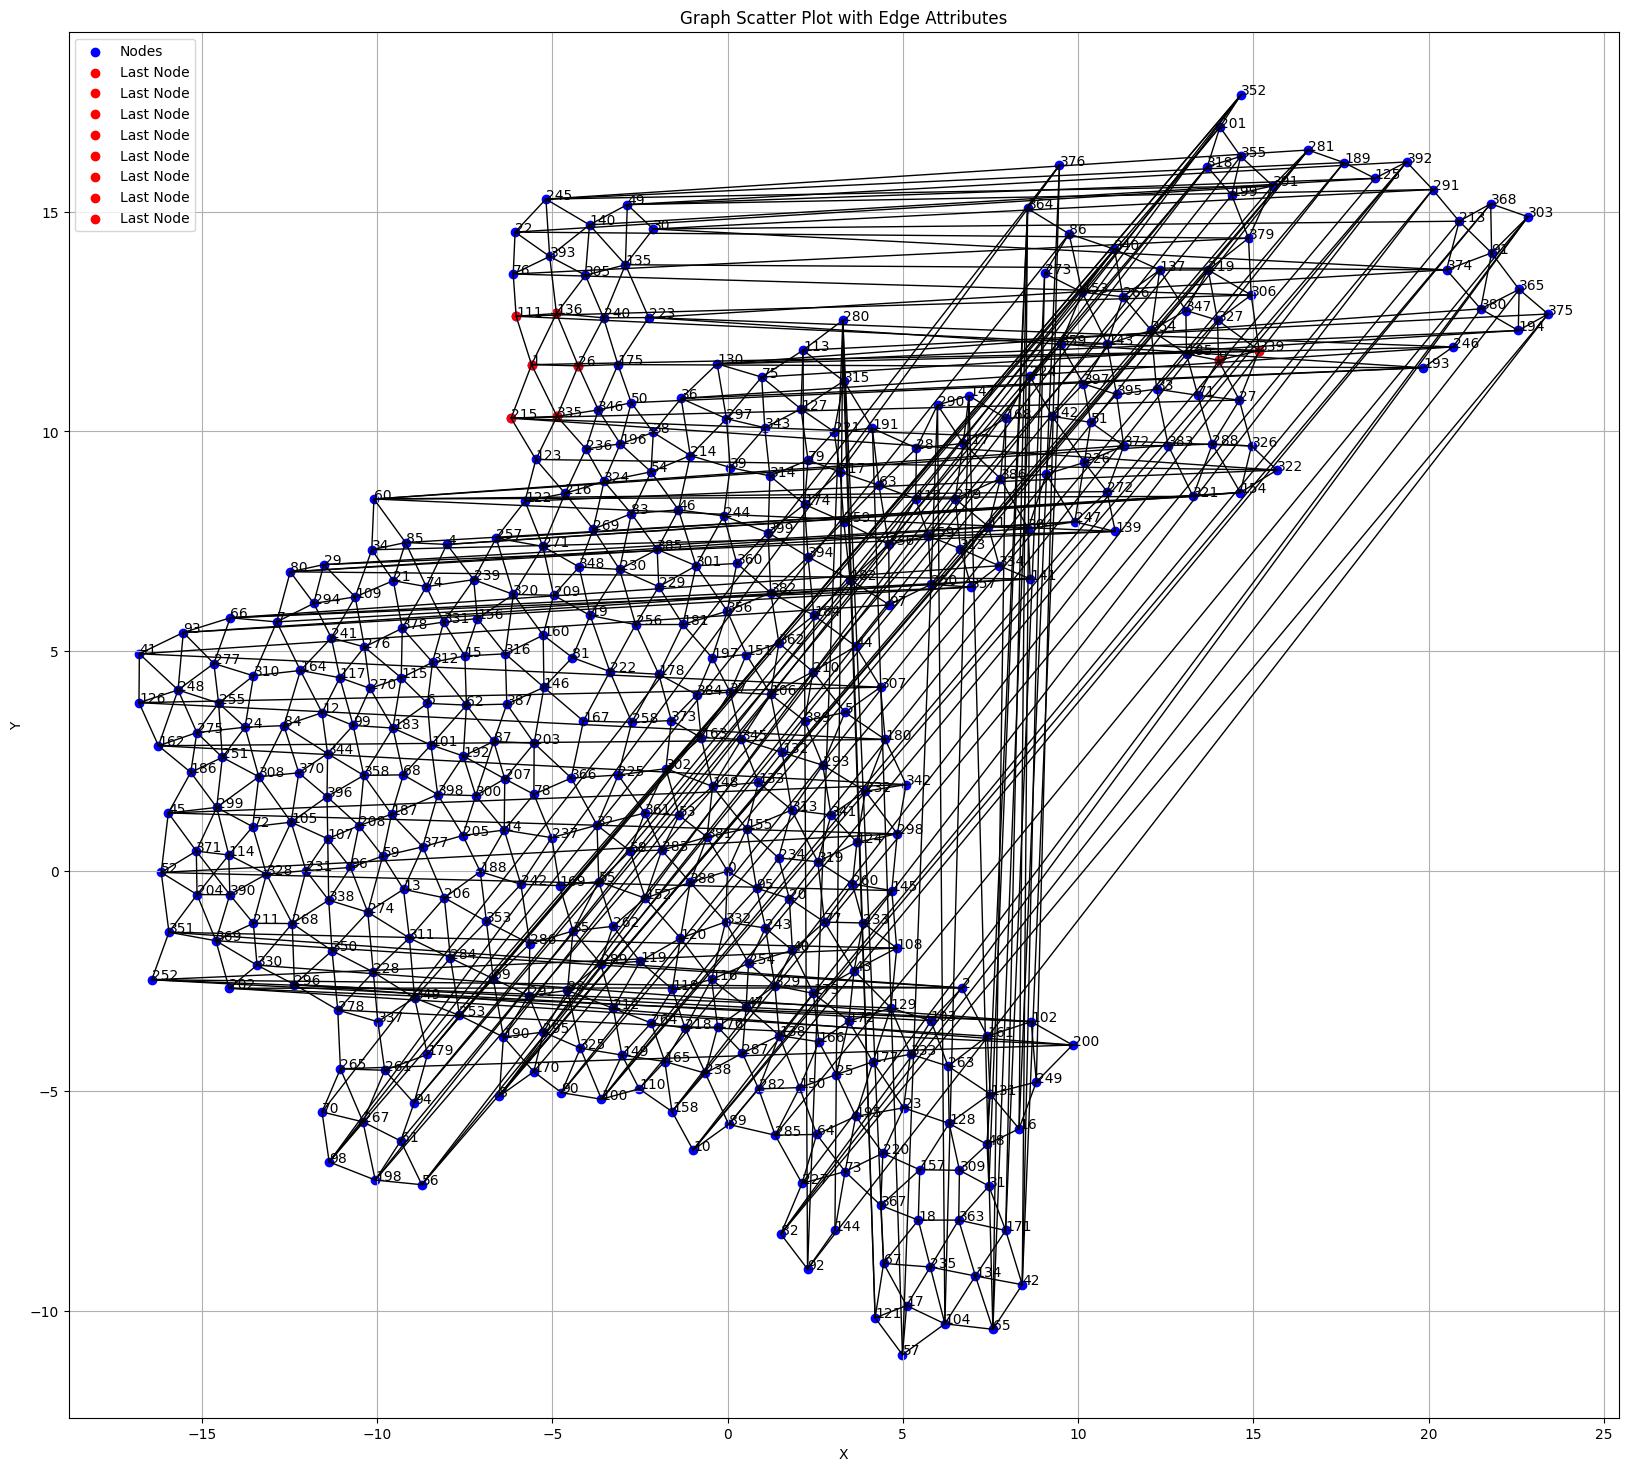

In [ ]:
#  Function to compute node positions
def compute_positions(edge_index, edge_attr, num_nodes):
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def dfs(node):
        visited[node] = True  # Mark the current node as visited
        # Iterate through all edges
        for i, (start, end) in enumerate(edge_index.T):
            # If the edge starts from the current node and the destination node hasn't been visited yet
            if start == node and not visited[end]:
                dx, dy = edge_attr[i, 1], edge_attr[i, 2]  # Get relative position from edge attributes
                # Update position of the destination node based on the relative position
                positions[end] = positions[start] + np.array([dx, dy])
                # Recursively call DFS on the destination node
                dfs(end)
            # If the edge ends at the current node and the source node hasn't been visited yet
            elif end == node and not visited[start]:
                dx, dy = edge_attr[i, 1], edge_attr[i, 2]  # Get relative position from edge attributes
                # Update position of the source node based on the relative position
                positions[start] = positions[end] - np.array([dx, dy])
                # Recursively call DFS on the source node
                dfs(start)

    # Visit all components
    for node in range(num_nodes):
        # If the node hasn't been visited yet, start DFS from that node
        if not visited[node]:
            dfs(node)

    return positions

num_nodes = data.x.size(0)
positions = compute_positions(data.edge_index.numpy(), data.edge_attr.numpy(), num_nodes)
print(positions[26])
print(positions[111])
print(positions[136])
print(positions[215])
print(positions[335])
print(positions[339])

# Extract edge attributes for annotations
edge_distances = data.edge_attr[:, 0].numpy()
relative_positions = data.edge_attr[:, 1:3].numpy()
relative_orientations = data.edge_attr[:, 3:5].numpy()

# Create a scatter plot of the nodes
plt.figure(figsize=(20, 18))
plt.scatter(positions[:, 0], positions[:, 1], c='blue', label='Nodes')

# Annotate nodes
for i, pos in enumerate(positions):
    plt.annotate(str(i), (pos[0], pos[1]))

# Draw edges with distance and orientation information
for i in range(0, data.edge_index.shape[1], 2):
    start, end = data.edge_index[:, i]
    x_coords = [positions[start, 0], positions[end, 0]]
    y_coords = [positions[start, 1], positions[end, 1]]
    plt.plot(x_coords, y_coords, 'k-', lw=1)  # Draw edge
    # mid_x = (x_coords[0] + x_coords[1]) / 2
    # mid_y = (y_coords[0] + y_coords[1]) / 2
    # plt.text(mid_x, mid_y, f'd={edge_distances[i]:.1f}', fontsize=8, color='red')
    # plt.text(mid_x, mid_y - 0.2, f'pos=({relative_positions[i, 0]:.1f},{relative_positions[i, 1]:.1f})', fontsize=8, color='green')
    # plt.text(mid_x, mid_y - 0.4, f'ori=({relative_orientations[i, 0]:.1f},{relative_orientations[i, 1]:.1f})', fontsize=8, color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
edge_dist=data.edge_attr[:,0].numpy()

In [ ]:
print(edge_dist)
print(edge_dist.max())

[1.3328849 1.3328849 1.0842893 ... 1.3686237 1.2636386 1.2636386]
1.3996183


In [ ]:
data=validation_dataset[0]

In [ ]:
print(data)

Data(x=[400, 3], edge_index=[2, 2208], edge_attr=[2208, 5], y=[400])


400
[[ 0.00000000e+00  0.00000000e+00]
 [ 2.13279732e+01  5.08409011e+00]
 [ 1.92407598e+01  5.76029002e+00]
 [-5.00334016e+00  1.19805900e+01]
 [ 1.35868298e+01  2.19659997e+00]
 [ 3.23396998e+01 -4.05905006e+00]
 [ 3.18015998e+01  3.05040499e+00]
 [-3.86915028e+00  1.51287901e+01]
 [-3.24442014e+00  1.05502901e+01]
 [ 2.45676998e+01 -4.26760080e-01]
 [ 1.71420003e+00  3.93379898e+00]
 [ 1.20159599e+01  4.75898995e+00]
 [ 3.03153998e+01 -3.32860025e-01]
 [ 4.66905998e+01 -1.44344100e+01]
 [ 1.98129598e+01  4.55829000e+00]
 [ 2.25989993e+00  1.49252900e+01]
 [ 3.14140999e+01  1.22549978e-01]
 [-6.98560021e+00  1.48089901e+01]
 [ 1.08860998e+01  4.94658995e+00]
 [-4.29877015e+00  1.01538901e+01]
 [ 1.60379986e+00  1.03889900e+01]
 [ 1.71038699e+01  6.13948991e+00]
 [ 1.85719798e+01 -1.79396989e+00]
 [ 3.40257298e+01  2.30556997e+00]
 [ 5.75479995e+00  8.32188991e+00]
 [ 1.00275997e+01  1.14655900e+01]
 [ 1.56424698e+01  6.95179951e-01]
 [ 2.26845998e+01 -2.91373003e+00]
 [-5.97192025e+0

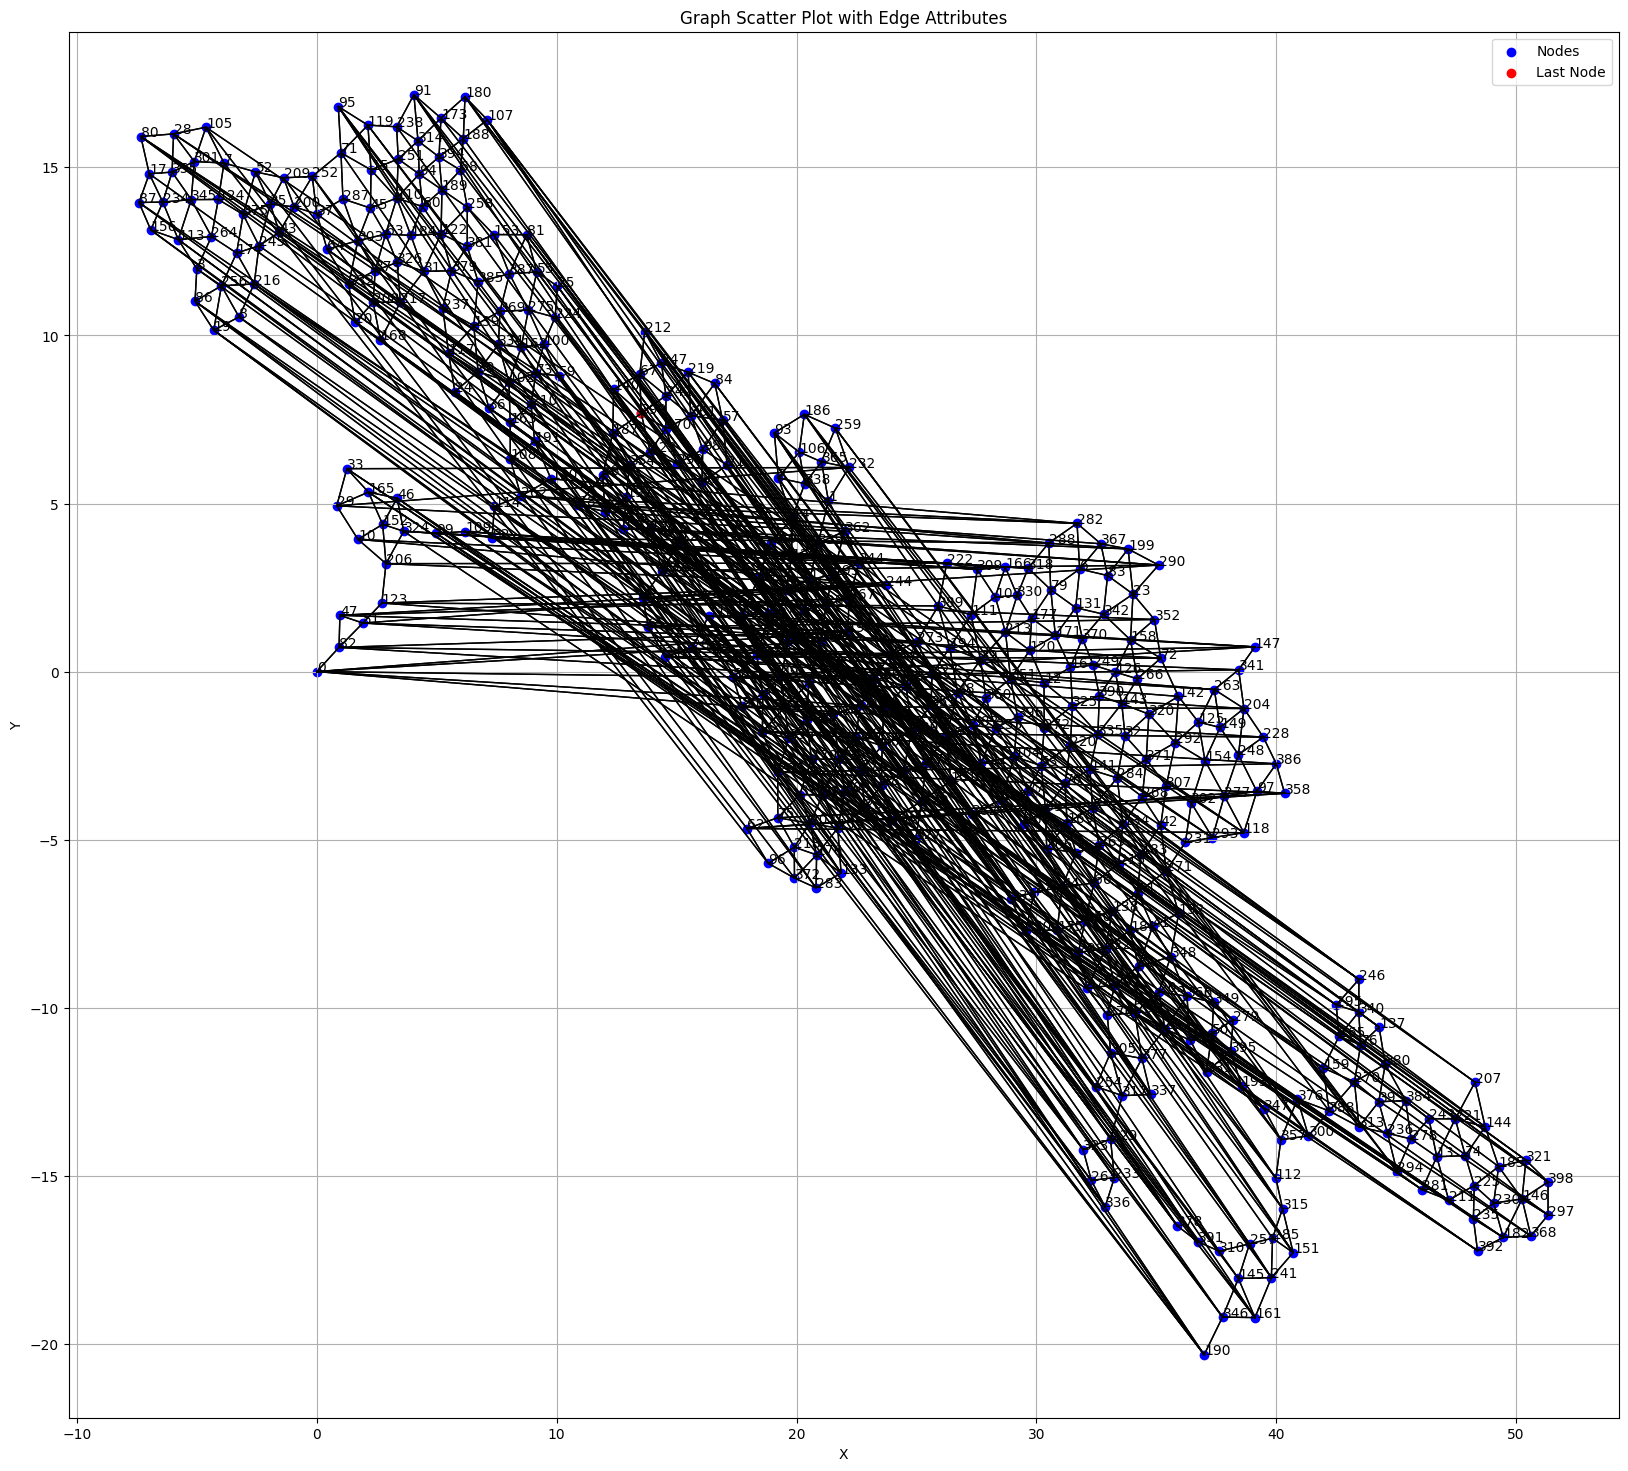

In [ ]:
# Function to compute node positions
def compute_positions(edge_index, edge_attr, num_nodes):
    positions = np.zeros((num_nodes, 2))  # Initialize positions array
    visited = np.zeros(num_nodes, dtype=bool)  # Track visited nodes

    def dfs(node):
        visited[node] = True
        for i, (start, end) in enumerate(edge_index.T):
            if start == node and not visited[end]:
                dx, dy = edge_attr[i, 1], edge_attr[i, 2]
                positions[end] = positions[start] + np.array([dx, dy])
                dfs(end)
            elif end == node and not visited[start]:
                dx, dy = edge_attr[i, 1], edge_attr[i, 2]
                positions[start] = positions[end] - np.array([dx, dy])
                dfs(start)

    # Visit all components
    for node in range(num_nodes):
        if not visited[node]:
            dfs(node)

    return positions

num_nodes = data.x.size(0)
positions = compute_positions(data.edge_index.numpy(), data.edge_attr.numpy(), num_nodes)
print(len(positions))
print(positions)

# Extract edge attributes for annotations
edge_distances = data.edge_attr[:, 0].numpy()
relative_positions = data.edge_attr[:, 1:3].numpy()
relative_orientations = data.edge_attr[:, 3:5].numpy()

# Create a scatter plot of the nodes
plt.figure(figsize=(20, 18))
plt.scatter(positions[:, 0], positions[:, 1], c='blue', label='Nodes')
last_node = positions[-1]
plt.scatter(last_node[0], last_node[1], c='red', label='Last Node')

# Annotate nodes
for i, pos in enumerate(positions):
    plt.annotate(str(i), (pos[0], pos[1]))

# Draw edges with distance and orientation information
for i, (start, end) in enumerate(data.edge_index.T):
    x_coords = [positions[start, 0], positions[end, 0]]
    y_coords = [positions[start, 1], positions[end, 1]]
    plt.plot(x_coords, y_coords, 'k-', lw=1)  # Draw edge
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    # plt.text(mid_x, mid_y, f'd={edge_distances[i]:.1f}', fontsize=8, color='red')
    # plt.text(mid_x, mid_y - 0.2, f'pos=({relative_positions[i, 0]:.1f},{relative_positions[i, 1]:.1f})', fontsize=8, color='green')
    # plt.text(mid_x, mid_y - 0.4, f'ori=({relative_orientations[i, 0]:.1f},{relative_orientations[i, 1]:.1f})', fontsize=8, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph Scatter Plot with Edge Attributes')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[400, 3], edge_index=[2, 2208], edge_attr=[2208, 5], y=[400])
Number of nodes: 400
Number of edges: 2208
Average node degree: 5.52
Has isolated nodes: False
Is undirected: False
